# Dynamical Movement Primitives: RNNs and LQR

This model is an RNN / Control Theory implementation of Stefan Schaal's 2007 Dynamical Movement Primitives Paper. The main components of this model are follows:
1. A nonlinear forcing function RNN model 
2. A linear transformation system that takes us to a specified attractor (goal) state

The nonlinear forcing function is high dimensional and learned through BPTT while the transformation system is low dimensional and is static. The learning occurs when we compare the output of the forcing RNN + transformation state space model (SSM) to the desired position. This error is then backpropagated to the forcing function.

In [44]:
# Import libraries
import numpy as np
import control
import matplotlib.pyplot as plt
import torch
import torch.nn as nn # All the neural network modules
import torch.optim as optim

## Specifying the Model : Sine Curve

### Trajectory parameters

In [45]:
dt = 0.01
tau_train = 1
timepoints = np.arange(0,1,dt/tau_train)
y_des_train = np.sin(np.arange(0, 1, dt/tau_train) * 5)
# y_des_train = np.zeros(timepoints.shape)
# y_des_train[int(len(y_des_train) / 2.0) :] = 0.5
goal = y_des_train[-1]

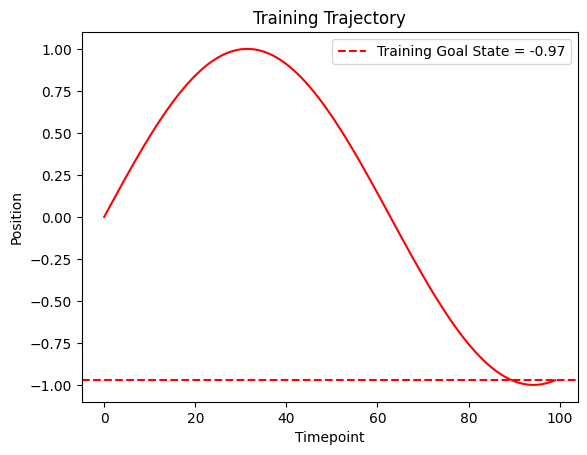

In [46]:
plt.figure()
plt.plot(y_des_train, 'r')
plt.axhline(y_des_train[-1], color = 'red', linestyle = '--', label = "Training Goal State = "+f'{y_des_train[-1]:.2f}')
plt.xlabel("Timepoint")
plt.ylabel("Position")
plt.title("Training Trajectory")
plt.legend()
plt.show()

The Linear Quadratic Regulator is a method to get a model to converge to an attractor state. We do this by finding K such that we get the optimal control policy **u = -Kr**.

### Linear Quadratic Regulator

Specify the LQR parameters:

In [47]:
hidden_units = 2
n_input = 1
Wr=np.random.normal(0,1,hidden_units**2)
Wr.shape=(hidden_units,hidden_units)
B = np.ones((hidden_units, n_input))

W_y = np.random.normal(0,1,hidden_units)
W_y.shape=(1,hidden_units)
# W_y = np.array([1, 0])

Q = np.eye(hidden_units)
R = np.eye(n_input)
# R[0,0]=20
R[0,0]=500

D = 0

K, S, E = control.dlqr(Wr, B, Q, R)

Calculate and plot the optimal control policy

In [48]:
Atilde = Wr- np.matmul(B, K)

sys_lqr = control.StateSpace(Atilde, B, W_y, D, dt = True)
ss_results_lqr = control.step_response(sys_lqr)

K_constant = (1/control.dcgain(sys_lqr))
Btilde = B* K_constant*goal
scaled_sys_lqr = control.StateSpace(Atilde, Btilde, W_y, D, dt = True)  
# sys_results_scaled = control.step_response(scaled_sys_lqr, T = 100,return_x = True)
(time, y_base, state_base)  = control.step_response(scaled_sys_lqr, T = int(1/(dt/tau_train))-1,return_x = True)


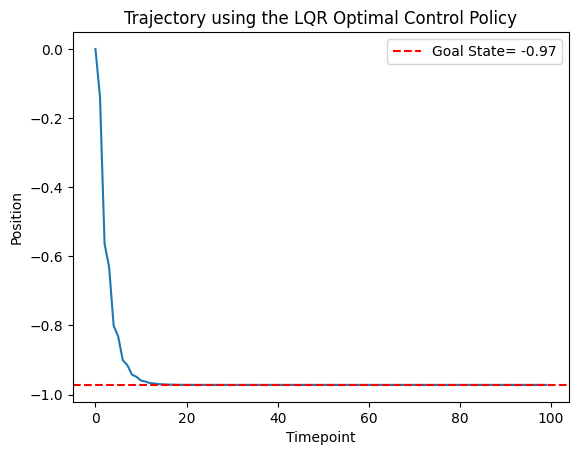

In [49]:
plt.figure()
plt.title("Trajectory using the LQR Optimal Control Policy")
plt.plot(y_base)
plt.axhline(y=goal, color='r', linestyle='--', label = "Goal State= "+f'{y_des_train[-1]:.2f}')
plt.xlabel("Timepoint")
plt.ylabel("Position")
plt.legend()
plt.show()

### Specify the Forcing RNN Model

Model hyperparameters

In [50]:
hidden_size_forcing = 100
hidden_size_trans = hidden_units
num_layers_forcing = 1
num_layers_trans = 1
learning_rate = 0.01
num_epoch = 1000
sequence_length = 5
batch_size = int(int(1/(dt/tau_train))/sequence_length)
output_size = 1
input_size_forcing = 1
input_size_trans = 1

In [51]:
batch_size

20

Model specification

In [52]:
class DMP_RNN(nn.Module):
    def __init__(self, hidden_size_forcing, hidden_size_trans,
                 num_layers_forcing, num_layers_trans,
                 learning_rate, num_epoch, sequence_length, batch_size, output_size, input_size_forcing, input_size_trans):
        super(DMP_RNN, self).__init__()
        self.hidden_size_forcing = hidden_size_forcing
        self.hidden_size_trans = hidden_size_trans
        
        self.num_layers_forcing = num_layers_forcing
        self.num_layers_trans = num_layers_trans
        
        self.learning_rate = learning_rate
        self.num_epoch = num_epoch
        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.output_size = output_size
        self.input_size_forcing = input_size_forcing
        self.input_size_trans = input_size_trans
        
        self.rnn_forcing = nn.RNN(self.input_size_forcing, self.hidden_size_forcing, self.num_layers_forcing,batch_first=True)
        self.fc_forcing=nn.Linear(self.hidden_size_forcing, self.output_size, bias = True)
        
#         self.fc_trans=nn.Linear(self.input_size_trans, self.output_size, bias = False)
    
    def forward_forcing(self, x):
        h0 = torch.randn(self.num_layers_forcing,self.batch_size, self.hidden_size_forcing)
        output_forcing, _ = self.rnn_forcing(x, h0)
        pred_forcing = self.fc_forcing(output_forcing)
        return pred_forcing


Model, optimizer, and loss definition

In [53]:
DMP_System = DMP_RNN(hidden_size_forcing, hidden_size_trans,
             num_layers_forcing, num_layers_trans,
             learning_rate, num_epoch, sequence_length, batch_size, output_size, input_size_forcing, input_size_trans)

criterion=nn.MSELoss()
optimizer=optim.Adam(DMP_System.parameters(),lr=learning_rate)

## Model Training

First we will generate the input for the forcing function -- exponential decay to 0

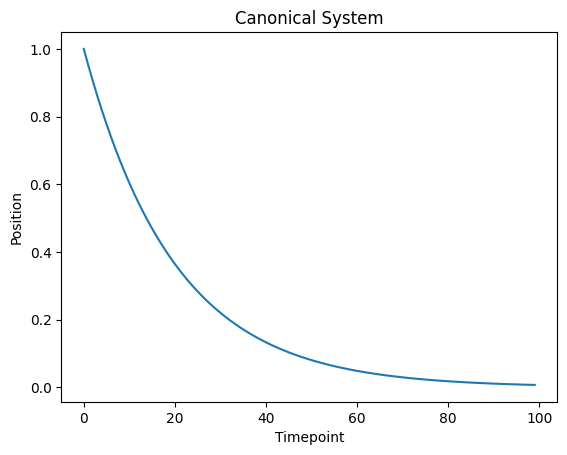

In [54]:
alpha = 5
tvals = np.linspace(0,1,int(1/(dt/tau_train)))
xvals = np.exp((-1*alpha/tau_train)*tvals)
xvals = np.array(xvals)

plt.figure()
plt.title("Canonical System")
plt.plot(xvals)
plt.xlabel("Timepoint")
plt.ylabel("Position")
plt.show()

Now we will train the model:

In [55]:
loss_list=[]
Atilde = torch.tensor(Atilde).float()
Btilde = torch.tensor(Btilde).float()
W_y = torch.tensor(W_y).float()
D = torch.tensor(D).float()
r_initial = torch.zeros((1,DMP_System.hidden_size_trans))
# r_initial = torch.tensor(([2.7, 5.2]))

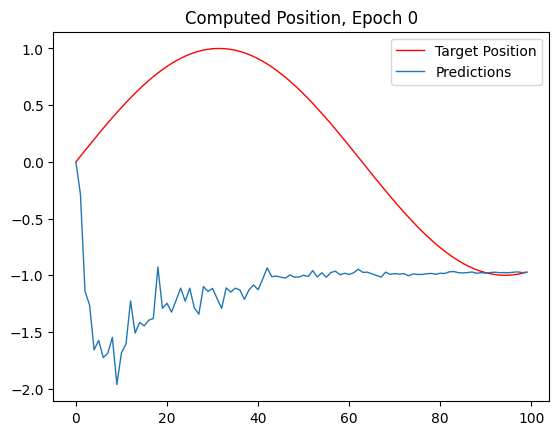

Epoch Number: 0, Loss Value: 2.2438623905181885


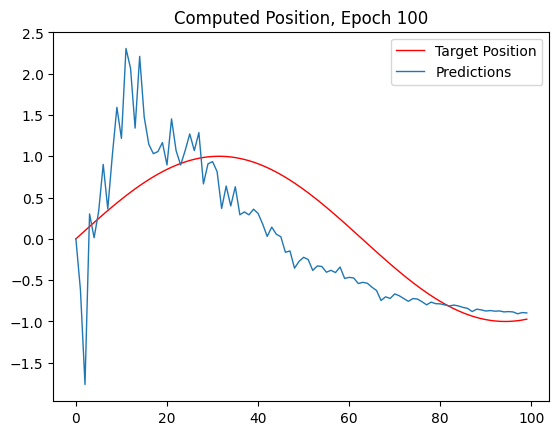

Epoch Number: 100, Loss Value: 0.35115063190460205


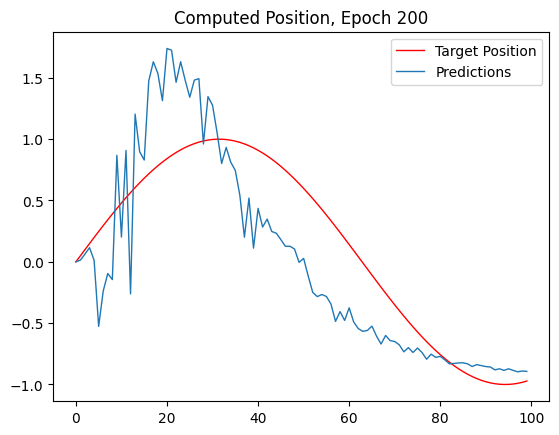

Epoch Number: 200, Loss Value: 0.21472255885601044


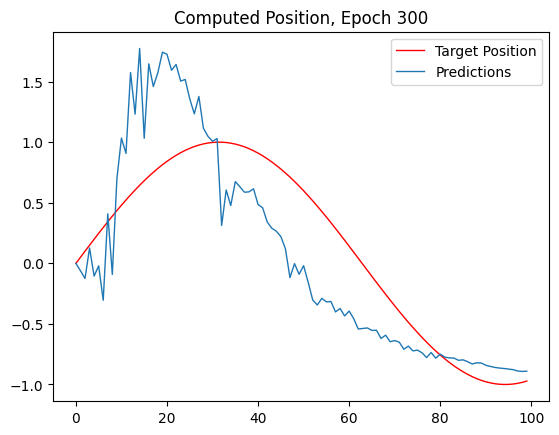

Epoch Number: 300, Loss Value: 0.2273186892271042


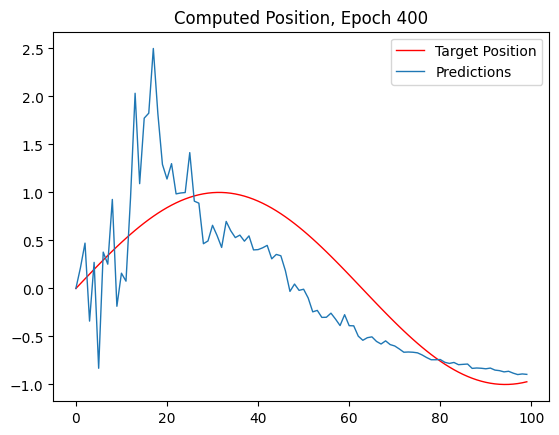

Epoch Number: 400, Loss Value: 0.24274732172489166


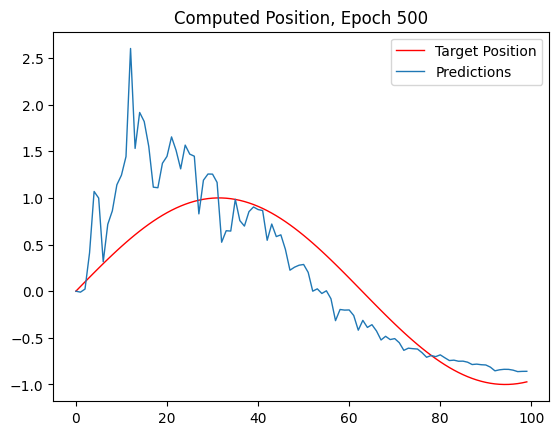

Epoch Number: 500, Loss Value: 0.20349641144275665


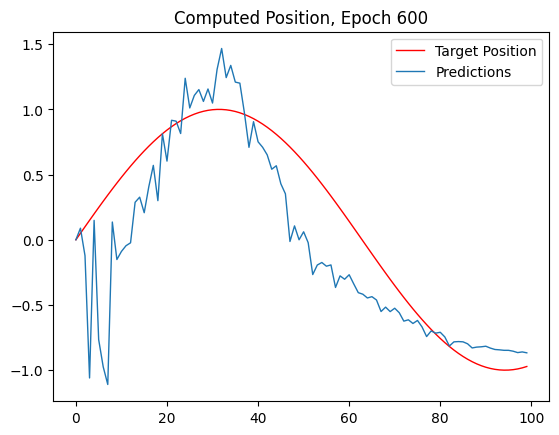

Epoch Number: 600, Loss Value: 0.16485825181007385


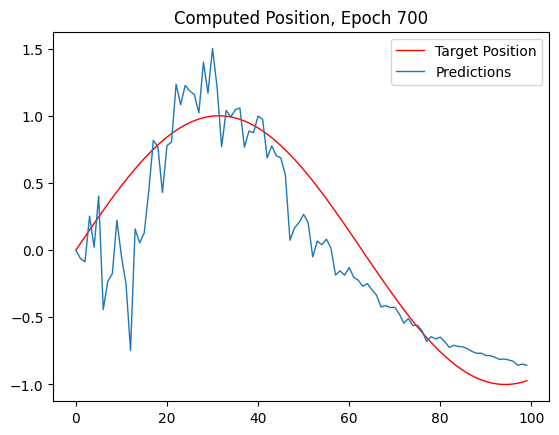

Epoch Number: 700, Loss Value: 0.09579089283943176


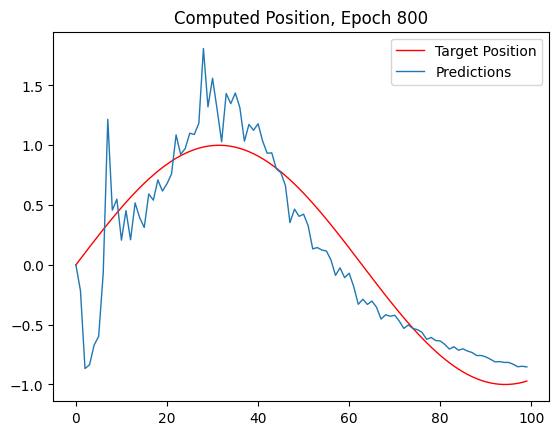

Epoch Number: 800, Loss Value: 0.09405782073736191


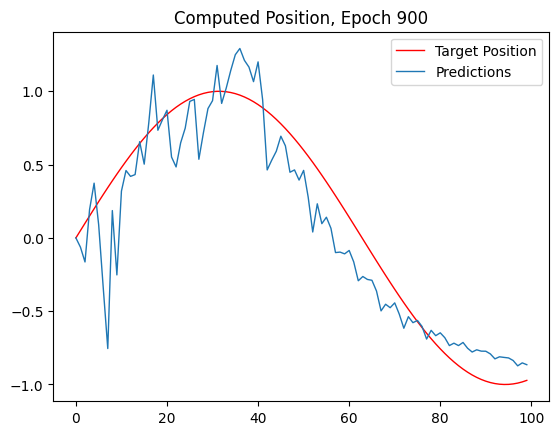

Epoch Number: 900, Loss Value: 0.06218158081173897


In [56]:
for epoch in range(num_epoch):
    # Training
    DMP_System.batch_size = batch_size
    inputs = torch.tensor(xvals).float()
    inputs=inputs.reshape(DMP_System.batch_size, DMP_System.sequence_length, DMP_System.input_size_forcing)
    # forcing_preds=DMP_System.forward_forcing(inputs)
    forcing_preds=inputs*DMP_System.forward_forcing(inputs)
    # forcing_preds=forcing_preds*inputs*(goal-y_des_train[0])
    forcing_preds_arr=forcing_preds.detach().numpy()
    forcing_preds_arr.shape = (DMP_System.batch_size*DMP_System.sequence_length,)
    # plt.plot(forcing_preds_arr)
    # forcing_preds_list[:,epoch] = forcing_preds_arr
    # forcing_input_to_ssm = DMP_System.fc_trans(forcing_preds)
    forcing_input_to_ssm = forcing_preds
    
    # y_list = DMP_System.forward_trans(forcing_input_to_ssm)
    # yhat_arr = torch.zeros((timepoints.shape[0],1))
    # DMP_System.fc_to_output.weight = nn.Parameter(torch.tensor(W_y).float())
    # DMP_System.fc_to_output.weight.requires_grad = False
    
    # # We want to create a new state space model with the input from the forcing function
    # u = forcing_input_to_ssm.detach().numpy()
    # # u.shape = (batch_size*sequence_length,DMP_System.hidden_size_trans)
    # u.shape = (100,1)
    # system = (Atilde, Btilde, W_y, D, dt/tau_train)
    # t_in = np.linspace(0,1,int(1/(dt/tau_train)))
    # tout, yout, xout = scipy.signal.dlsim(system, u, t=t_in)
    
    #r_initial = torch.tensor([[0],[0]]).float()
    # r_initial = np.zeros((DMP_System.hidden_size_trans,1))
    # r_state = r_initial
    # C = torch.tensor(W_y).float()
    # y_list = torch.empty(0, 1) 
    # r_state_vec = torch.zeros((100,2))
    # counter = 0
    # y_list = torch.empty(0, 1)

    # for b in range(DMP_System.batch_size):
    #     forcing_input_to_ssm_batch = forcing_input_to_ssm[b,:,:]
    #     for t in range(0, DMP_System.sequence_length):
    #         forcing_val = forcing_input_to_ssm_batch[t,:]
    #         # forcing_val = forcing_val.reshape(DMP_System.hidden_size_trans, 1)
    #         forcing_val_arr = forcing_val.detach().numpy()
    #         # forcing_val = torch.zeros((hidden_size_trans,1))
    #         # forcing_val.requires_grad = True
    #         rprime = np.matmul(Atilde, r_state) + B*goal*K_constant +forcing_val_arr
    #         r_state += rprime*(dt/tau_train)
    #         r_state_torch = torch.tensor(r_state).float()
    #         y = DMP_System.fc_to_output(r_state_torch.T)
    #         # y = np.matmul(W_y, r_state)
    #         # y=DMP_System.fc_to_output(r_state.T)
    #         # y_list.append(float(y))
    #         # y_list = torch.cat((y_list, y), axis =0)
    #         y_list = torch.vstack((y_list, y))
    
    forcing_input_to_ssm = forcing_input_to_ssm.reshape(batch_size*sequence_length, 1)
    # forcing_val = forcing_input_to_ssm.detach().numpy()
    u_dt = torch.ones((timepoints.shape[0],1))
    u_dt = u_dt.reshape(batch_size*sequence_length, 1)
    # u_dt.shape = (batch_size*sequence_length, 1)
    
#     r_initial = torch.zeros((1,DMP_System.hidden_size_trans))
    rout = torch.zeros((timepoints.shape[0], DMP_System.hidden_size_trans), requires_grad=False)
    yout = torch.zeros((timepoints.shape[0], DMP_System.output_size), requires_grad = False)
    
    rout[0,:] = r_initial
    for t in range(0, timepoints.shape[0] - 1):
        rout[t+1, :] = (torch.matmul(Atilde, rout[t, :]) +
                        torch.matmul(Btilde, u_dt[t, :]) +
                        forcing_input_to_ssm[t,:])
        yout[t, :] = torch.matmul(W_y, rout[t, :])

    
    
    # forcing_val = forcing_input_to_ssm.detach().numpy()
    # forcing_val.shape = (batch_size*sequence_length, 1)
    # u_dt = np.ones((timepoints.shape[0],1))
    # u_dt.shape = (batch_size*sequence_length, 1)
    
    # # Simulate the system
    # r_initial = np.zeros((1,DMP_System.hidden_size_trans))
    # rout = np.zeros((timepoints.shape[0], DMP_System.hidden_size_trans))
    # yout = np.zeros((timepoints.shape[0], DMP_System.output_size))
    # rout[0,:] = r_initial
    # for t in range(0, timepoints.shape[0] - 1):
    #     rout[t+1, :] = (np.dot(Atilde, rout[t, :]) +
    #                     np.dot(Btilde, u_dt[t, :]) +
    #                     forcing_val[t,:])
    #     yout[t, :] = np.tanh(np.dot(W_y, rout[t, :]) +
    #                   np.dot(D, u_dt[t, :]))

    # Last point
    yout[timepoints.shape[0]-1, :] = (torch.matmul(W_y, rout[timepoints.shape[0]-1, :]))

    #tout, y, xout = scipy.signal.dlsim(system, u, t = timepoints)
    # yout.shape = (batch_size, sequence_length, output_size)
    # y_list = yout.clone()
    # y_list = torch.tensor(yout).float()
    # y_list.requires_grad = True
    
    targets=torch.tensor(y_des_train).float()
    targets=targets.reshape(batch_size, sequence_length, output_size)
    yout = yout.reshape(batch_size, sequence_length, output_size)
    optimizer.zero_grad()
    loss = criterion(yout, targets)
    loss_list.append(loss.item())
    
    loss.backward()
    optimizer.step()
    
    yhat_arr = yout.detach().numpy()
    yhat_arr.shape = (batch_size*sequence_length,)
    
    
    if epoch%100 ==0:
        plt.clf();
        plt.ion()
        plt.title(str("Computed Position, ")+"Epoch {}".format(epoch))
        plt.plot(y_des_train,'r-',linewidth=1,label='Target Position')
        plt.plot(yhat_arr,linewidth=1,label='Predictions')
        plt.legend()
        plt.draw();
        plt.pause(0.05);
        
        print("Epoch Number: "+str(epoch)+", Loss Value: "+str(loss.item()))


Let's look at the final trajectory of the trained model

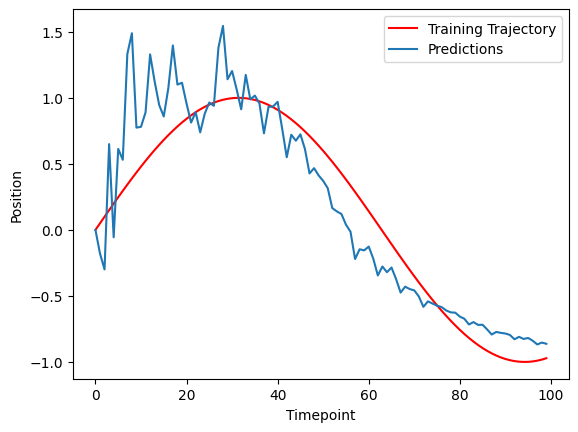

In [57]:
plt.figure()
plt.plot(y_des_train,'r',label="Training Trajectory")
plt.plot(yhat_arr, label ="Predictions")
plt.xlabel("Timepoint")
plt.ylabel("Position")
plt.legend()
plt.show()

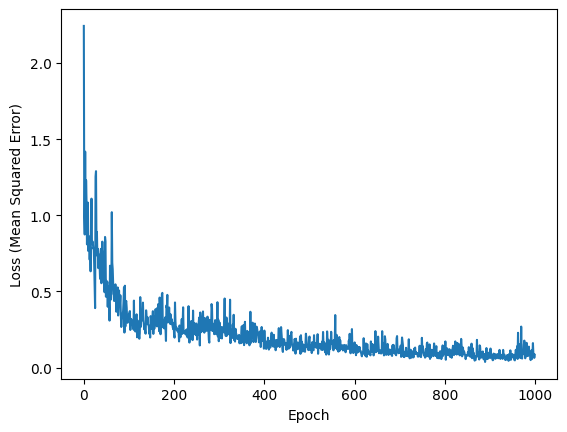

In [58]:
plt.figure()
plt.plot(loss_list)
plt.xlabel("Epoch")
plt.ylabel("Loss (Mean Squared Error)")
plt.show()

## Testing the model: Spatial Invariance

We will first see how well this model generalizes to new goal states (i.e. goal states that are not the training goal state). The RNN will remained unchanged but in order to generalize to the testing goal state we need to recompute the LQR SSM

### Specify the testing trajectory parameters

In [59]:
tau_test = 1
timepoints_test = np.arange(0,1,dt/tau_test)
y_des_test = np.sin(np.arange(0, 1, dt/tau_test) * 5)
# y_des_test = np.zeros(timepoints_test.shape)
# y_des_test[int(len(y_des_test) / 2.0) :] = goal_test
goal_test = 5
y_des_test[-1]=goal_test

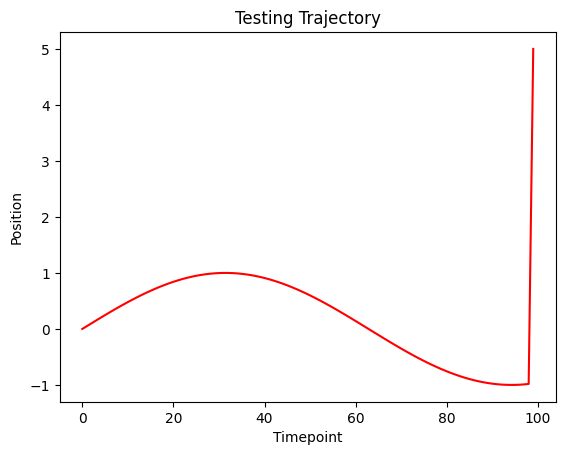

In [60]:
plt.figure()
plt.plot(y_des_test, 'r')
plt.title("Testing Trajectory")
plt.xlabel("Timepoint")
plt.ylabel("Position")
plt.show()

The goal of our model is not to approximate this trajectory. The goal of our model is to reach the goal location flexibly but that also still contains the same stereotyped behavior of the training trajectory

### Recompute the LQR solution

In [61]:
Btilde_test = B* K_constant*goal_test
scaled_sys_lqr_test = control.StateSpace(Atilde, Btilde_test, W_y, D, dt = True)  
# sys_results_scaled = control.step_response(scaled_sys_lqr, T = 100,return_x = True)
(time_test, y_base_test, state_base_test)  = control.step_response(scaled_sys_lqr_test, T = int(1/(dt/tau_test))-1,return_x = True)


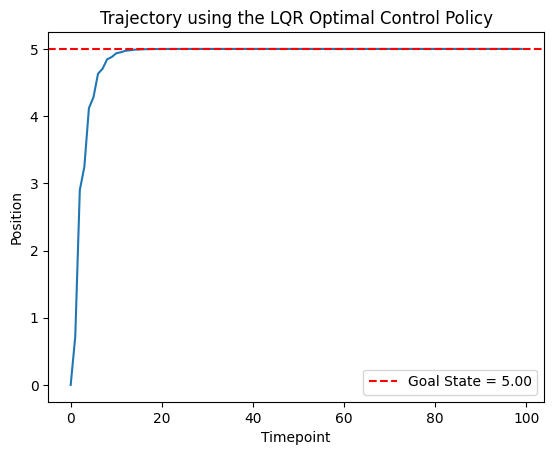

In [62]:
plt.figure()
plt.title("Trajectory using the LQR Optimal Control Policy")
plt.plot(y_base_test)
plt.axhline(y=goal_test, color='r', linestyle='--', label = "Goal State = "+ f'{y_des_test[-1]:.2f}')
plt.xlabel("Timepoint")
plt.ylabel("Position")
plt.legend()
plt.show()

In [63]:
# Generate the canonical system
tvals_test = np.linspace(0,1,int(1/(dt/tau_test)))
xvals_test = np.exp(-1*alpha*tvals_test)
xvals_test = np.array(xvals_test)

In [64]:
# Validate the model 

batch_size_test = int(int(1/(dt/tau_test))/sequence_length)
DMP_System.batch_size = batch_size_test
inputs_test = torch.tensor(xvals_test).float()
inputs_test=inputs_test.reshape(DMP_System.batch_size, DMP_System.sequence_length, DMP_System.input_size_forcing)

forcing_preds_test=inputs_test*DMP_System.forward_forcing(inputs_test)
# forcing_preds_arr=forcing_preds.detach().numpy()
# forcing_preds_arr.shape = (DMP_System.batch_size*DMP_System.sequence_length,)
# plt.plot(forcing_preds_arr)
# forcing_preds_list[:,epoch] = forcing_preds_arr
# forcing_input_to_ssm_test = DMP_System.fc_trans(forcing_preds_test)
forcing_input_to_ssm_test = forcing_preds_test

forcing_input_to_ssm_test = forcing_input_to_ssm_test.reshape(batch_size_test*sequence_length, 1)
# forcing_val = forcing_input_to_ssm.detach().numpy()
u_dt_test = torch.ones((timepoints_test.shape[0],1))
u_dt_test = u_dt_test.reshape(batch_size_test*sequence_length, 1)
# u_dt.shape = (batch_size*sequence_length, 1)
Btilde_test = torch.tensor(Btilde_test).float()
# r_initial = torch.zeros((1,DMP_System.hidden_size_trans))
rout_test = torch.zeros((timepoints_test.shape[0], DMP_System.hidden_size_trans), requires_grad=False)
yout_test = torch.zeros((timepoints_test.shape[0], DMP_System.output_size), requires_grad = False)

rout_test[0,:] = r_initial
for t in range(0, timepoints_test.shape[0] - 1):
    rout_test[t+1, :] = (torch.matmul(Atilde, rout_test[t, :]) +
                    torch.matmul(Btilde_test, u_dt_test[t, :]) +
                    forcing_input_to_ssm_test[t,:])
    yout_test[t, :] = torch.matmul(W_y, rout_test[t, :])

yout_test[timepoints_test.shape[0]-1, :] = (torch.matmul(W_y, rout_test[timepoints_test.shape[0]-1, :]))

yout_test_arr=yout_test.detach().numpy()
yout_test_arr.shape = (batch_size_test*sequence_length,1)

In [65]:
yout_test_arr[50]

array([6.2470446], dtype=float32)

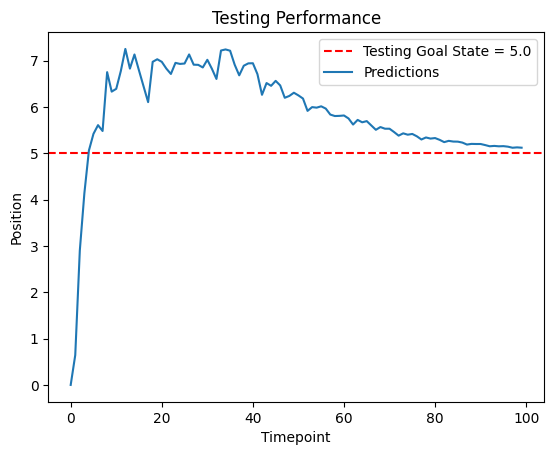

In [66]:
plt.figure()
plt.title("Testing Performance")
plt.axhline(y_des_test[-1], color = 'r', linestyle = '--', label = "Testing Goal State = "+str(y_des_test[-1]))
# plt.plot(y_des_test, 'r', label ='Testing Trajectory')
plt.plot(yout_test_arr, label = 'Predictions')
plt.xlabel("Timepoint")
plt.ylabel("Position")
plt.legend()
plt.show()

Now let's kick the trajectory off it's course at timepoint 50 by setting the position value to -10

In [73]:
rout_test_kicked = torch.zeros((timepoints_test.shape[0], DMP_System.hidden_size_trans), requires_grad=False)
yout_test_kicked = torch.zeros((timepoints_test.shape[0], DMP_System.output_size), requires_grad = False)

rout_test_kicked[0,:] = r_initial
for t in range(0, timepoints_test.shape[0] - 1):
    if t==50:
        yout_test_kicked[t, :] = -10
    else:
        rout_test_kicked[t+1, :] = (torch.matmul(Atilde, rout_test_kicked[t, :]) +
                        torch.matmul(Btilde_test, u_dt_test[t, :]) +
                        forcing_input_to_ssm_test[t,:])
        yout_test_kicked[t, :] = torch.matmul(W_y, rout_test_kicked[t, :])

yout_test_kicked[timepoints_test.shape[0]-1, :] = (torch.matmul(W_y, rout_test_kicked[timepoints_test.shape[0]-1, :]))

yout_test_arr_kicked=yout_test_kicked.detach().numpy()
yout_test_arr_kicked.shape = (batch_size_test*sequence_length,1)

In [74]:
yout_test_arr_kicked[50]

array([-10.], dtype=float32)

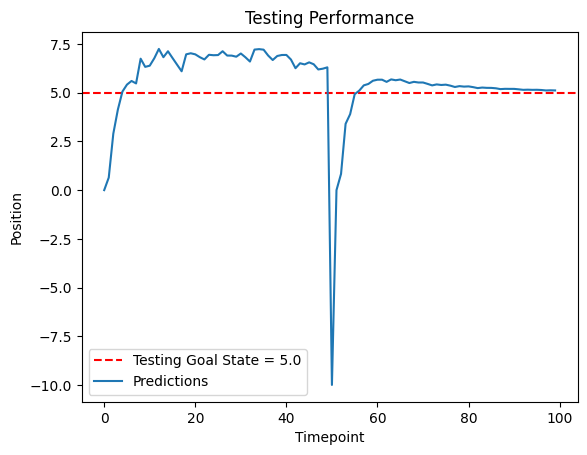

In [75]:
plt.figure()
plt.title("Testing Performance")
plt.axhline(y_des_test[-1], color = 'r', linestyle = '--', label = "Testing Goal State = "+str(y_des_test[-1]))
# plt.plot(y_des_test, 'r', label ='Testing Trajectory')
plt.plot(yout_test_arr_kicked, label = 'Predictions')
plt.xlabel("Timepoint")
plt.ylabel("Position")
plt.legend()
plt.show()

We see that our model is able to adapt quickly to the strong perturbation